# ANÁLISIS Y PROCESAMIENTO DE DATOS DE INUMET


Comenzaremos análizando los datos tal cual nos fueron entregados (en archivos .csv), para luego realizar un procesamiento de los mismos. A continuación se muestran algunos de los registros al azar de cada una de las 3 estaciones meteorológicas.

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas
import warnings

import warnings
warnings.filterwarnings('ignore')

paths = [("Prado", "INUMET/INUMET_original_Prado.csv"), ("Carrasco", "INUMET/INUMET_original_Carrasco.csv"), ("Melilla", "INUMET/INUMET_original_Melilla.csv")]
dfsOriginales = {}

print("\n")

print("Mostramos algunos de los registros de cada estación:\n")

for (nombre, path) in paths:
    df = pd.read_csv(path)
    dfsOriginales[nombre] = df

    print(nombre + ":")
    print(df.sample(10), "\n")



Mostramos algunos de los registros de cada estación:

Prado:
     Estacion            Fecha  Tmax  Tmin
617     Prado   9/10/2014 0:00  16.0  11.5
12      Prado   1/13/2013 0:00  29.3  19.6
907     Prado   6/28/2015 0:00  18.9  17.0
218     Prado    8/7/2013 0:00  17.6  11.5
2127    Prado  10/31/2018 0:00  20.6  14.0
329     Prado  11/26/2013 0:00  19.0  17.5
1033    Prado   11/1/2015 0:00  19.4   7.8
2247    Prado   2/28/2019 0:00  20.8  14.4
128     Prado    5/9/2013 0:00  24.6  12.9
820     Prado    4/1/2015 0:00  25.4  11.6 

Carrasco:
       Estacion            Fecha  Tmax  Tmin
2456  Carrasco    9/25/2019 0:00  26.2  10.6
2490  Carrasco   10/29/2019 0:00  17.6  15.6
830   Carrasco    4/11/2015 0:00  22.0  17.0
2128  Carrasco    11/1/2018 0:00  20.6  11.7
1240  Carrasco    5/25/2016 0:00  14.6   5.4
706   Carrasco    12/8/2014 0:00  26.6  14.6
2483  Carrasco   10/22/2019 0:00  19.9   8.0
1609  Carrasco    5/29/2017 0:00  16.0   9.0
1491  Carrasco    1/31/2017 0:00  29.5  21.5
92

Algo que nos llamó la atención es que el atributo 'Fecha' no es del tipo 'date', sino que también incluye la hora. Esto no nos es de ninguna utilidad, mas que nada porque esta siempre es la misma para cada registro. Por lo tanto, lo que haremos será separar la fecha de la hora, y luego convertir la fecha a un tipo 'date' y también conventirlo en el índice del DataFrame.

In [154]:
dfsModificados = {}

print("\n")

print("Mostramos algunos de los registros de cada estación luego de modificar el atributo 'Fecha':\n")

for (nombre, df) in dfsOriginales.items():

    # borro los las hh:mm de la columna "Fecha"
    df['Fecha'] = df['Fecha'].replace('0:00', '')
    # paso los strings a date
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    # indicamos la columna fecha como indice
    df = df.set_index('Fecha')

    dfsModificados[nombre] = df

    print(nombre + ":")
    print(df.sample(10), "\n")



Mostramos algunos de los registros de cada estación luego de modificar el atributo 'Fecha':

Prado:
           Estacion  Tmax  Tmin
Fecha                          
2013-08-19    Prado  23.7  11.0
2019-01-25    Prado  27.9  18.1
2015-05-13    Prado  21.0  12.3
2016-04-15    Prado  22.6  20.5
2014-07-01    Prado  11.6   9.6
2019-09-07    Prado  17.2  11.9
2015-09-22    Prado  13.6  11.4
2014-02-04    Prado  29.6  17.4
2014-06-21    Prado  17.8   5.4
2018-12-30    Prado  25.8  19.2 

Carrasco:
             Estacion  Tmax  Tmin
Fecha                            
2015-11-02  Carrasco   19.2  10.5
2016-08-23  Carrasco   21.8   7.1
2013-05-11  Carrasco   22.2  15.5
2019-03-31  Carrasco   22.7  17.0
2013-04-22  Carrasco   23.8  13.5
2016-07-24  Carrasco   10.8   7.4
2015-12-12  Carrasco   35.0  21.0
2019-01-04  Carrasco   27.4  12.4
2015-02-28  Carrasco   23.7  12.2
2013-05-08  Carrasco   22.0   7.8 

Melilla:
            Estacion  Tmax  Tmin
Fecha                           
2015-08-12  Melil

Pasamos a analizar algunos factores de calidad de los datos, como la cantidad de datos faltantes, la cantidad de datos duplicados.

In [155]:
print("\n")

print("Catidad de datos totales y duplicados por estación:\n")

for (nombre, df) in dfsModificados.items():

    print(nombre + ":")
    print(df.shape[0], "registros totales")
    # detectamos duplicados en el indice del DataFrame, o sea, en en atributo "Fecha"
    print(df.index.duplicated().sum(), "registros duplicados\n")




Catidad de datos totales y duplicados por estación:

Prado:
2554 registros totales
0 registros duplicados

Carrasco:
2554 registros totales
0 registros duplicados

Melilla:
2547 registros totales
0 registros duplicados



Como podemos ver, la cantidad de registros es la misma para las estaciones de Prado y Carrasco (2554), pero hay 7 registros menos para la estación de Melilla (2547). Esperamos una cantidad de 2556 registros para cada estación (365 * 7 + 1, siendo 7 la cantidad de años con la que contamos y el +1 por ser 2016 año bisiesto). Procedemos a analizar cuales son los registros que faltan para poder completarlos. Por suerte no hay ningún registro duplicado (o sea, que tengan la misma fecha).

In [156]:
# defino un DataFrame con todas las fechas desde 2013-01-01 hasta 2019-12-31, este DataFrame tiene size 2556
dfFechas = pd.DataFrame({'Fecha': pd.date_range(start='1/1/2013', end='31/12/2019', freq='D')})
dfFechas = dfFechas.set_index('Fecha')

print("\n")

print("Comletamos las fechas faltantes y mostramos registros con por lo menos una temperatura nula:\n")

for (nombre, df) in dfsModificados.items():
    
    # unimos los DataFrames dfFechas y df, los registros que no coincidan en el indice se completan con NaN
    df = dfFechas.join(df, how='left')
    # rellenamos la columna 'Estacion' con el nombre de la estación, ya que ahora hay NaN en esa columna para las fechas nuevas
    df['Estacion'] = nombre
    dfsModificados[nombre] = df

    print(nombre + ":")
    print("Cantidad de registros luego de agregar las fechas faltantes:", df.shape[0])
    print("Cantidad de registros con alguna temperatura nula:", df[df['Tmin'].isnull() | df['Tmax'].isnull()].shape[0], "\n")
    print(df[df['Tmin'].isnull() | df['Tmax'].isnull()], "\n")



Comletamos las fechas faltantes y mostramos registros con por lo menos una temperatura nula:

Prado:
Cantidad de registros luego de agregar las fechas faltantes: 2556
Cantidad de registros con alguna temperatura nula: 14 

           Estacion  Tmax  Tmin
Fecha                          
2013-01-04    Prado   NaN  17.5
2013-01-05    Prado   NaN  20.0
2013-01-06    Prado   NaN  22.7
2013-04-25    Prado  25.8   NaN
2015-04-06    Prado   NaN   NaN
2016-07-14    Prado   NaN   NaN
2016-09-17    Prado  20.2   NaN
2016-09-18    Prado  14.1   NaN
2016-09-19    Prado  12.6   NaN
2016-09-20    Prado  17.7   NaN
2016-09-21    Prado  22.7   NaN
2016-09-22    Prado  25.9   NaN
2016-11-02    Prado  12.6   NaN
2016-11-05    Prado  31.0   NaN 

Carrasco:
Cantidad de registros luego de agregar las fechas faltantes: 2556
Cantidad de registros con alguna temperatura nula: 11 

            Estacion  Tmax  Tmin
Fecha                           
2016-03-03  Carrasco   NaN  18.5
2017-07-20  Carrasco   NaN   6

Lo que se hizo para rellenar las fechas faltantes fue definir un nuevo DataSet con una única columna "Fecha" que contenga todo el rango de fechas desde el 1/1/2013 hasta el 31/12/2019, o sea, 2556 días (registros en la tabla). Luego, iteramos en los DataSets de cada estación meteorológica realizando un join entre estos y el DataSet con el rango de fechas para así completar los registros faltantes con NaN. Observar que se rellena la columna 'Estación' con el nombre de la estación correspondiente, por lo que únicamente tendremos posiblews valores NaN en ambas columnas de temperatura. Ahora todos los DataSets de temperaturas tiene la cantidad de días que deberían tener.

Ahora que tenemos los datos completos (en el sentido de que no faltan registros, o sea días) procedemos a analizar la cantidad de datos faltantes por columna. Se impime, para cada estación, la cantidad de registro que tienen por lo menos un valor de NaN en la columnas de temperaturas. Observar que esta cantidad de registros con algún nulo es mayor que la cantidad de fechas que nos faltaban antes de hacer el join. Esto se debe a que en los datos originales existen registros con NaN en alguna de las columnas de temperatura.

Nuestra intención con estos registros será rellenarlos con algun valor distinto a NaN y para hacerlo calcularemos las temperaturas máximas y mínimas promedio de cada día del año, para los 7 años que tenemos datos y rellenamos los registros nulos con estos valores.

In [157]:
dfsPromedio = {}

print("\n")

print("Creamos un DataFrame con las temperaturas promedio de cada dia para cada una de las 3 estaciones. Rellenamos NaNs con estos valores.\n")

for (nombre, df) in dfsModificados.items():
    
    # calculamos el promedio de las temperaturas para cada dia
    dfPromedio = pd.DataFrame(columns=['Mes', 'Dia', 'Estacion', 'Tmax', 'Tmin'])
    for row in range(365):
        fecha = df.index[row]
        dia = fecha.day
        mes = fecha.month
        dfFiltro = df.loc[df.index.day == dia]
        dfFiltro = dfFiltro.loc[dfFiltro.index.month == mes]
        tmaxAvg = round(dfFiltro["Tmax"].mean(), 1)
        tminAvg = round(dfFiltro["Tmin"].mean(), 1)
        dfPromedio.loc[row] = [mes, dia, nombre, tmaxAvg, tminAvg]

    dfsPromedio[nombre] = dfPromedio

    print("DataFrame con promedios de temperatura mínima y máxima de la estación de " + nombre + ":\n")
    print(dfPromedio, "\n")

    # obtengo las rows que tiene NaN en la columna 'Tmax' o 'Tmin'
    print("Valores incompletos en las temperaturas \n")
    dfNulos = df[df['Tmin'].isnull() | df['Tmax'].isnull()]
    print(dfNulos)
    print("\n")

    # cambio los valores de NaN por el valor promedio de la temperatura
    for inx, row in dfNulos.iterrows():
        dia = inx.day
        mes = inx.month
        if pd.isnull(df["Tmin"][inx]):
            df["Tmin"][inx] = dfPromedio.loc[dfPromedio["Dia"] == dia].loc[dfPromedio["Mes"] == mes]["Tmin"]
            dfNulos["Tmin"][inx] = dfPromedio.loc[dfPromedio["Dia"] == dia].loc[dfPromedio["Mes"] == mes]["Tmin"]
        if pd.isnull(df["Tmax"][inx]):
            df["Tmax"][inx] = dfPromedio.loc[dfPromedio["Dia"] == dia].loc[dfPromedio["Mes"] == mes]["Tmax"]
            dfNulos["Tmax"][inx] = dfPromedio.loc[dfPromedio["Dia"] == dia].loc[dfPromedio["Mes"] == mes]["Tmax"]

    # muestro los valores que se cambiaron
    print("Registros que previamente eran nulos, ahora rellenados con el valor promedio: \n")
    print(dfNulos)
    print("\n")

# unimos los 3 dataframes en uno solo y lo guardamos en un archivo csv
dfFinal = pd.concat([dfsModificados['Carrasco'], dfsModificados['Melilla'], dfsModificados['Prado']])
dfFinal.to_csv("INUMET/INUMET_procesado.csv")



Creamos un DataFrame con las temperaturas promedio de cada dia para cada una de las 3 estaciones. Rellenamos NaNs con estos valores.

DataFrame con promedios de temperatura mínima y máxima de la estación de Prado:

     Mes  Dia Estacion  Tmax  Tmin
0      1    1    Prado  27.4  19.5
1      1    2    Prado  25.5  19.0
2      1    3    Prado  26.9  17.1
3      1    4    Prado  28.9  18.0
4      1    5    Prado  29.0  19.6
..   ...  ...      ...   ...   ...
360   12   27    Prado  29.6  20.8
361   12   28    Prado  30.9  20.2
362   12   29    Prado  31.4  21.5
363   12   30    Prado  30.1  21.5
364   12   31    Prado  27.7  20.2

[365 rows x 5 columns] 

Valores incompletos en las temperaturas 

           Estacion  Tmax  Tmin
Fecha                          
2013-01-04    Prado   NaN  17.5
2013-01-05    Prado   NaN  20.0
2013-01-06    Prado   NaN  22.7
2013-04-25    Prado  25.8   NaN
2015-04-06    Prado   NaN   NaN
2016-07-14    Prado   NaN   NaN
2016-09-17    Prado  20.2   NaN
2016-09

A este punto, ya tenemos los 3 DataSets de temperaturas completos, con todos los registros y sin valores nulos. De modo ilustrativo, se muestran a continuación algunas gráficas de las temperaturas máximas y mínimas de cada estación.



Gráficas de temperaturas para las distintas estaciones, luego del procesamiento: 

Prado:



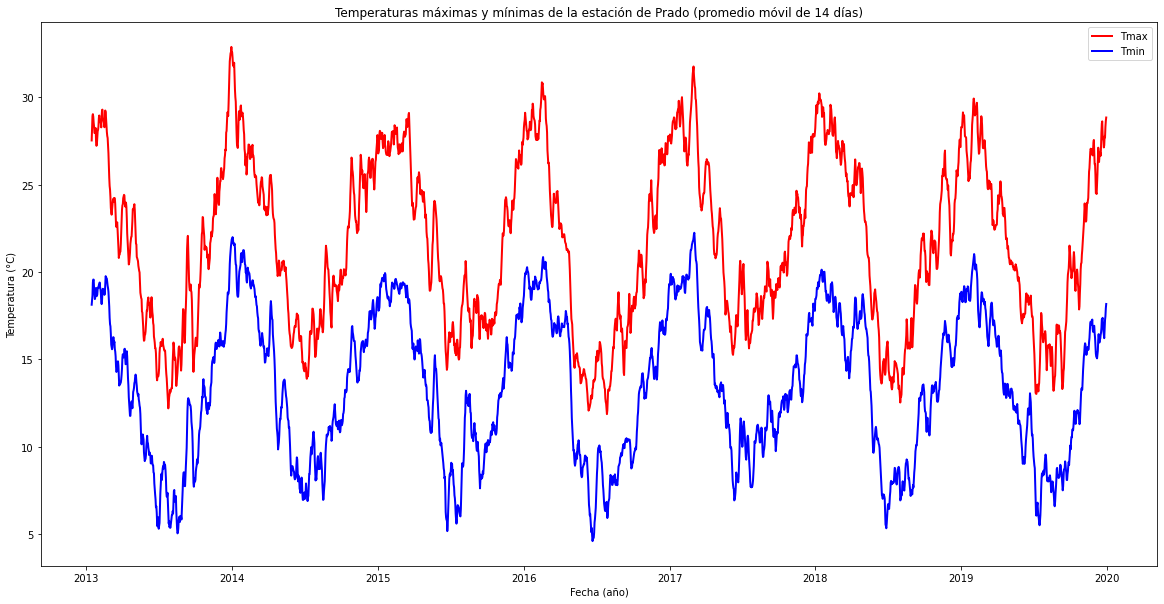

Carrasco:



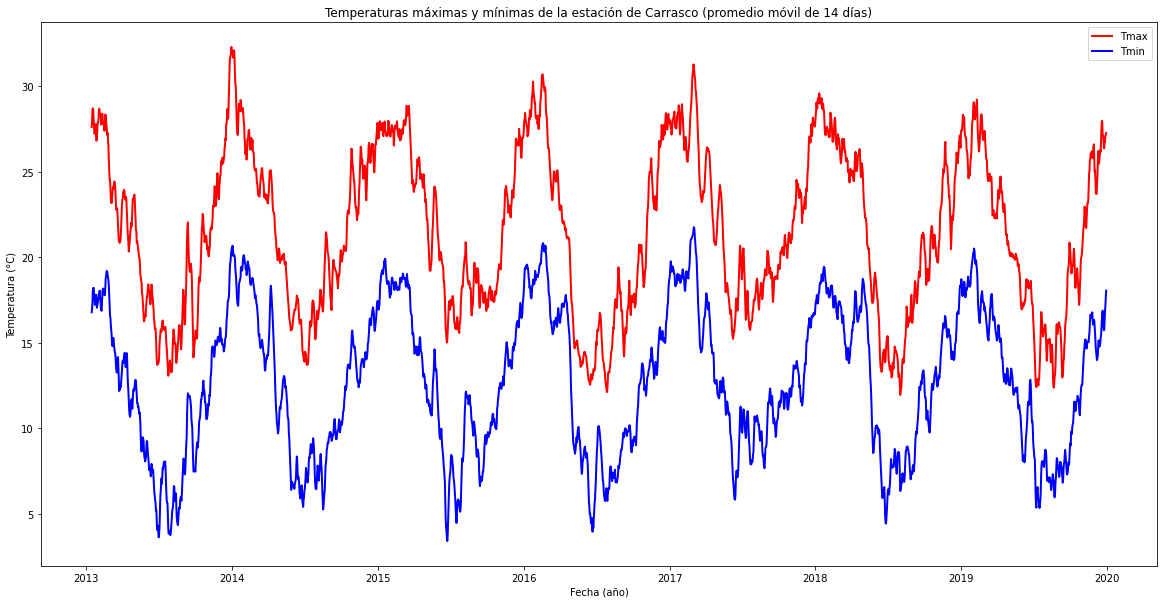

Melilla:



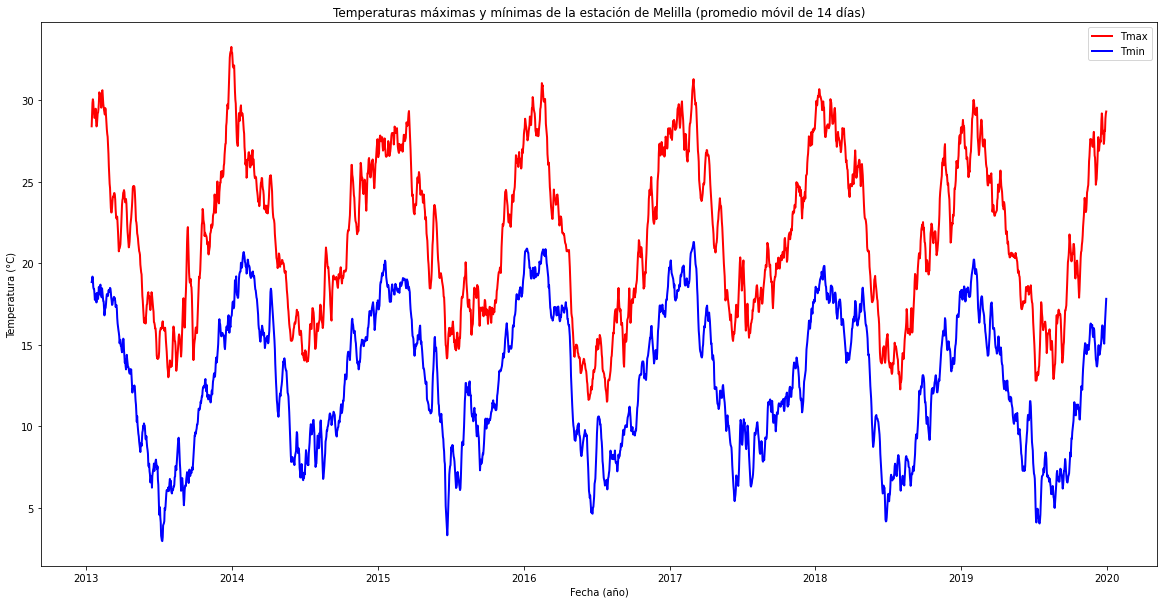

In [158]:
print("\n")

print("Gráficas de temperaturas para las distintas estaciones, luego del procesamiento: \n")

for (nombre, df) in dfsModificados.items():

    print(nombre + ':\n')

    plt.figure(figsize=(20, 10))
    plt.plot(df['Tmax'].rolling(14).mean(), label='Tmax', color='red', linewidth=2)
    plt.plot(df['Tmin'].rolling(14).mean(), label='Tmin', color='blue', linewidth=2)
    plt.title('Temperaturas máximas y mínimas de la estación de ' + nombre + ' (promedio móvil de 14 días)')
    plt.xlabel('Fecha (año)')
    plt.ylabel('Temperatura (°C)')
    plt.legend()
    plt.show()

No hay diferencias muy notorias entre las estaciones, lo que tiene sentido ya que todas estan ubicadas en Montevideo, por lo que están muy cernanas entre sí. Lo que si se puede observar es que la estación de Carrasco al estar más cerca del mar, tiene temperaturas un poco más bajas que las otras dos estaciones.

# PREPERANDO LOS DATOS PARA LA INTEGRACIÓN

Ahora que tenemos los 3 DataSets de temperaturas completos, procedemos a adaptarlos para la integración. Para hacerlo, primero debemos cambiar la periodicidad de los datos de diaria a mensual, ya que es con lo que se trabaja en otros DataSets. Para cada estación, tomaremos todos los días de cada mes y promediaremos sus valores de temperaturas y también extraeremos algunos datos extra que puedan ser de utilidad, como se muestra a continuación:

In [159]:
meses = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}
años = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']

dfsModificadosPromedio = {}

for (nombre, df) in dfsModificados.items():
    print('\n')
    print('Estadisticas promediadas por mes para la estación de ' + nombre + ':\n')
    dfFiltradoPromedio = pd.DataFrame(columns=['Año', 'Mes', 'Estacion', 'TMaxPromedio', 'TMinPromedio', 'TMaxRegistrada', 'TMinRegistrada', 'TMaxDesviacion', 'TMinDesviacion'])
    for año in años:
        for mes in meses:
            # filtramos el df en el mes y año correspondiente
            dfFiltrado = df.loc[(df.index.month == mes) & (df.index.year == int(año))]
            # obtengo los valores de interes
            promedioTMax = round(dfFiltrado['Tmax'].mean(), 1)
            promedioTMin = round(dfFiltrado['Tmin'].mean(), 1)
            maxTMax = dfFiltrado['Tmax'].max()
            minTMin = dfFiltrado['Tmin'].min()
            desviacionEstandarTMax = round(dfFiltrado['Tmax'].std(),1)
            desviacionEstandarTMin = round(dfFiltrado['Tmin'].std(),1)
            # agrego los valores al nuevo df
            dfFiltradoPromedio.loc[len(dfFiltradoPromedio)] = [año, mes, nombre, promedioTMax, promedioTMin, maxTMax, minTMin, desviacionEstandarTMax, desviacionEstandarTMin]
    
    dfFiltradoPromedio.set_index(['Año', 'Mes'], inplace=True)
    dfsModificadosPromedio[nombre] = dfFiltradoPromedio
    print(dfFiltradoPromedio)

# unimos los 3 dataframes en uno solo y lo guardamos en un archivo csv
dfFinal = pd.concat([dfsModificadosPromedio['Carrasco'], dfsModificadosPromedio['Melilla'], dfsModificadosPromedio['Prado']])
dfFinal.to_csv("INUMET/INUMET_promedio.csv")



Estadisticas promediadas por mes para la estación de Prado:

         Estacion  TMaxPromedio  TMinPromedio  TMaxRegistrada  TMinRegistrada  \
Año  Mes                                                                        
2013 1      Prado          28.0          18.8            34.4            11.9   
     2      Prado          26.7          18.1            33.5            11.9   
     3      Prado          23.2          14.7            30.4            10.0   
     4      Prado          22.5          13.9            26.7             7.7   
     5      Prado          18.1          10.8            24.6             4.3   
...           ...           ...           ...             ...             ...   
2019 8      Prado          15.8           8.2            26.3             2.5   
     9      Prado          17.7           8.8            27.6             3.8   
     10     Prado          19.7          12.4            29.0             6.6   
     11     Prado          25.7          16.3 

Como podemos ver, ahora tenemos 84 registros (7 años * 12 meses) por estación. Aprovenchando que tenemos información de extra al comprimir los datos diarios de INUMET a datos mensuales, agregamos algunas variables nuevas al DataSet de INUMET. Estas variables son: 

* Temperatura máxima promedio del mes (TMaxPromedio)
* Temperatura mínima promedio del mes (TMinPromedio)
* Temperatura máxima registrada en todo el mes (TMaxRegistrada)
* Temperatura mínima registrada en todo el mes (TMinRegistrada)
* Desviación estándar de las temperaturas máximas del mes (TMaxDesviacion)
* Desviación estándar de las temperaturas mínimas del mes (TMinDesviacion)

Hasta este punto llegaría lo que es el procesamiento del DataSet de INUMET por si solo, a partir de aquí se relacionará con el DataSet de la INE, el cual define a las distintas secciones y segmentos en las que se divide Montevideo. Este DataSet nos provee con una representación geográfica de cada sección y segmento, por lo que podemos relacionar los datos de INUMET con los datos de la INE mediante la latitud y longitud de cada una de las estaciones de INUMET, de forma que a cada sección y segmento se le asigne una única estación (la mas cercana físicamente) de la cual tomará los datos de temperatura por mes.

Primero que nada debemos ubicar geográficamente las estaciones de INUMET, ya que este dato no nos fue provisto directamente junto a los datos de temperaturas. Las coordenadas de las estaciones se conocen publicamente, por lo que a continuación creamos un nuevo DataFrame, que contenga las coordenadas de las estaciones y sus nombres.

In [160]:
# leemos el archivo .shp que contiene los poligonos de las secciones y segmentos
dfSecSegm = geopandas.read_file("INE - IDE\censo11-segm\seg_hog11.shp")

# pasamos al crs adecuado (EPSG:4326 es estandar para latitud y longitud)
dfSecSegm .to_crs('EPSG:4326', inplace=True)

# filtrar unicamente para Montevideo (contiene secciones-segmentos de todo el país)
dfSecSegm  = dfSecSegm .loc[dfSecSegm ['nombdepto'] == 'MONTEVIDEO']

# nos quedamos únicamente con las que nos interesan
dfSecSegm = dfSecSegm[['seccion', 'segmento', 'geometry']]

# agrego una nueva columna "estacion" a dfSecSegm
dfSecSegm ['Estacion'] = ''

# creo un nuevo DataSet para las ubicaciones de las estaciones
dfEstaciones = pd.DataFrame(columns=['Estacion', 'Latitud', 'Longitud'])
# lozalizacion de la estación de Carrasco
carrascoPoint = Point(-56.03736, -34.87783)
dfEstaciones.loc[len(dfEstaciones)] = ['Carrasco', -34.87783, -56.03736]
# lozalizacion de la estación de Prado
pradoPoint = Point(-56.20713, -34.86074)
dfEstaciones.loc[len(dfEstaciones)] = ['Prado', -34.86074, -56.20713]
# lozalizacion de la estación de Melilla
melillaPoint = Point(-56.26313, -34.78911)
dfEstaciones.loc[len(dfEstaciones)] = ['Melilla', -34.78911, -56.26313]
# guardo el nuevo DataSet
dfEstaciones.to_csv("INUMET/Estaciones.csv", index=False)

# itero en cada sección-segmento y veo que estacion esta mas cerca, le asigno el valor correspondiente en la columma 'Estacion'
for inx, row in dfSecSegm.iterrows():
    if row.geometry.distance(carrascoPoint) < row.geometry.distance(pradoPoint) and row.geometry.distance(carrascoPoint) < row.geometry.distance(melillaPoint):
        dfSecSegm.at[inx, 'Estacion'] = 'Carrasco'
    elif row.geometry.distance(pradoPoint) < row.geometry.distance(carrascoPoint) and row.geometry.distance(pradoPoint) < row.geometry.distance(melillaPoint):
        dfSecSegm.at[inx, 'Estacion'] = 'Prado'
    elif row.geometry.distance(melillaPoint) < row.geometry.distance(carrascoPoint) and row.geometry.distance(melillaPoint) < row.geometry.distance(pradoPoint):
        dfSecSegm.at[inx, 'Estacion'] = 'Melilla'
    else:
        # no se pudo deterimnar
        dfSecSegm.at[inx, 'Estacion'] = ''

# luego de la asignación ya no precisamos la columna geometry
dfSecSegmEstacion = dfSecSegm[['seccion', 'segmento', 'Estacion']]
# guardo el nuevo DataSet
dfSecSegmEstacion.to_csv("INUMET/Estaciones_INE.csv", index=False)

# muestro el mapa cambiando el color en base a la estación asignada
dfSecSegm.explore("Estacion", cmap="autumn", legend=False)

Con la ayuda de Google/Google Maps pudimos obtener las ubicaciones de las estaciones de INUMET, las cuales quedan guardadas en una nueva tabla 'estaciones'. Haciendo uso de estas ubicaciones y del atributo 'geometry' del DataSet de INE que define una sección-segmento en el mapa, calculamos la distancia entre cada estación y cada sección-segmento y le asignamos la más cercana. En el mapa podemos ver en color naranja las secciones y segmentos a las que se les asignó la estacion de Melilla, en amarillo la estación de Prado y en rojo la estación de Carrasco. Esta asignación quedó guardada en la tabla 'Estaciones_INE'. Lo único que con falta es obtener un DataSet final que tenga como identificador el año, mes, sección y segmento y que contenga los datos de temperatura de la estación más cercana a cada sección-segmento, lo cual se hace a continuación.

In [161]:
dfFinal.reset_index(inplace=True)
dfINUMET_INE = dfSecSegmEstacion.merge(dfFinal, left_on=['Estacion'], right_on=['Estacion'], how='inner')
dfINUMET_INE = dfINUMET_INE[['seccion', 'segmento', 'Año', 'Mes', 'TMaxPromedio', 'TMinPromedio', 'TMaxRegistrada', 'TMinRegistrada', 'TMaxDesviacion', 'TMinDesviacion']].set_index(['seccion', 'segmento', 'Año', 'Mes'])
dfINUMET_INE.to_csv("INUMET/INUMET_INE.csv")    
dfINUMET_INE

TMaxPromedio  TMinPromedio  TMaxRegistrada  \
seccion segmento Año  Mes                                               
0.0     0.0      2013 1            28.0          18.8            34.4   
                      2            26.7          18.1            33.5   
                      3            23.2          14.7            30.4   
                      4            22.5          13.9            26.7   
                      5            18.1          10.8            24.6   
...                                 ...           ...             ...   
99.0    255.0    2019 8            15.0           7.4            26.0   
                      9            17.2           7.9            27.2   
                      10           18.9          11.9            29.0   
                      11           24.9          15.6            33.6   
                      12           26.3          16.4            34.9   

                           TMinRegistrada  TMaxDesviacion  TMinDesviacion  
seccion segmento Año  Mes                                                  
0.0     0.0      2013 1              11.9             3.6             2.7  
                      2              11.9             3.8             3.1  
                      3              10.0             3.5             3.3  
                      4               7.7             3.0             3.1  
                      5               4.3             3.3             2.9  
...                                   ...             ...             ...  
99.0    255.0    2019 8               1.2             4.6             3.1  
                      9               2.8             5.1             3.0  
                      10              3.6             4.6             3.4  
                      11             11.2             3.7             2.1  
                      12             10.4             4.6             3.5  

[89292 rows x 6 columns]

Donde se hizo un join entre las tablas 'Estaciones_INE' e 'INUMET_promedio' por el atributo 'Estacion'. Debido a que contamos con 1063 pares sección-segmento diferentes en Montevideo y hay un total de 12 x 7 = 84 meses, tendremos un total de 1063 x 84 = 89292 registros en esta tabla final 'INUMET_INE'. Esta tabla tiene como indice los atributos 'seccion', 'segmento', 'Año' y 'Mes'. Aqui termina el procesamiento de los datos de INUMET.